## Problem Statement
---
`Next Realtors` is one of the top performing real estate agencies in Ames, Iowa, having been in the business for almost 20 years. The firm is well known in the local market for its top notch service and excellent follow up. However, there have been some new agencies that have claimed to be able to offer better price assessments of properties as compared to us.

The agency has thus hired a new team of data analysts to help develop a `price prediction tool` for the company. This tool should be able to predict the likely sale price of a property with `at least 80% accuracy`, and `identify prominent features` of the property that can affect the sale price. 

Using this tool, our agents can then assess properties and help our clients to clinch the best deals. Home sellers can identify what type of addition or remodelling could be done to effectively boost their expected sale price, while home buyers can expect to get the best deals based on the budget they have and the type of facilities they may be expecting.

# Contents
- [Background](#Background)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Modelling (Separate Notebook)](model.ipynb)
- [Conclusion (Separate Notebook)](model.ipynb)

Due to the complexity of the data and length of analysis required, modelling will be split into a separate notebook as linked. We will also assess the performance of the model and make recommendations in the separate notebook.

# Background
---
Ames is a city in Iowa, with a small population of around 66,000 as of the 2020 US Census. The city is located near the intersection of Interstate 35 and US Route 30, with a smaller highway US Route 69 passing through. With a humid continental climate, on average the warmest month is July and the coldest month is January.

Home ownership is relatively low in Ames compared to the US, with only around 41% of housing units in Ames being occupied by their owners. This is likely due to the large student population in the city. Iowa State University is home to 33,000 students as of fall 2019, which makes up approximately half of the city's entire population. Of this student population, at least 50% of the students are from outside of Iowa state and will likely either stay on campus or rent an apartment in the city.

![Ames Homeownership 2020](../images/ames_ownership.png)<br>
[Source: Data USA](https://datausa.io/profile/geo/ames-ia/#housing)

As part of Next Realtor's renewal efforts, they have been digitalising their property transaction records, starting with the oldest records dating back to 2006. However, to date only transactions up till 2010 have been digitalised, with the remaining records expected to be complete by early 2023. The agency has provided this data from `2006 to 2010` for our initial analysis and modelling. The data includes various features and grading of the properties, including the target variable `sale price`, which we are expecting to predict, and a [data documentation](../DataDocumentation.txt) has been provided.

In order to evaluate our prediction model's performance, a section of the data provided to us has had the sale price omitted, with the actual sale prices being encoded in an online portal "Kaggle". Once we have predictions of the expected sale prices, we can submit it to this portal and it will score the accuracy of our predictions. 

# Data Cleaning
---
Prior to analysing the data in the train set, we will check that there are no missing values in our data and ensure that it is of the correct object type for analysis.

In [158]:
# import required libraries
import pandas as pd
pd.set_option("display.max_rows", 60) # expand display due to large dataset
pd.set_option("display.max_columns", 30) # expand display due to large dataset

from math import log
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

In [159]:
# import train data
df = pd.read_csv("../datasets/train.csv")
print(df.shape)

(2051, 81)


In [160]:
# create function to rename columns to snake case, print column names to check
def rename(dataframe):
    dataframe.columns = dataframe.columns.str.lower().str.replace(" ", "_") # convert column names to snake_case
    print(dataframe.columns)

In [161]:
rename(df)

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

Excluding our target variable `saleprice`, there are 80 features (columns) in the data set and 2051 different transactions (rows) for analysis. Due to the large number of features, we will split them into categories for easier data cleaning and preparation. Based on the provided data dictionary, the features can be split into the following:
- Categorical
    - Nominal
    - Ordinal
- Numerical
    - Discrete
    - Continuous

During the data cleaning, we will also identify and drop features that do not display much utility. We will use lists to store the features that we are interested to explore as part of our subsequent EDA. This will also allow us to subsequently apply an appropriate imputation and/or transformation method to the features during modelling.

In [162]:
# identify and separate features by variable type based on data dictionary
nominal_var = ["id", "pid", "ms_subclass", "ms_zoning", "street", "alley", "land_contour", "lot_config", "neighborhood", 
                "condition_1", "condition_2", "bldg_type", "house_style", "roof_style", "roof_matl", "exterior_1st", 
                "exterior_2nd", "mas_vnr_type", "foundation", "heating", "central_air", "garage_type", "misc_feature",
                "sale_type"]
ordinal_var = ["lot_shape", "utilities", "land_slope", "overall_qual", "overall_cond", "exter_qual", "exter_cond", "bsmt_qual",
                "bsmt_cond", "bsmt_exposure", "bsmtfin_type_1", "bsmtfin_type_2", "heating_qc", "electrical",
                "kitchen_qual", "functional", "fireplace_qu", "garage_finish", "garage_qual", "garage_cond", "paved_drive",
                "pool_qc", "fence"]
discrete_var = ["year_built", "year_remod/add", "bsmt_full_bath", "bsmt_half_bath", "full_bath", "half_bath", "bedroom_abvgr",
                "kitchen_abvgr", "totrms_abvgrd", "fireplaces", "garage_yr_blt", "garage_cars", "mo_sold", "yr_sold"]
continuous_var = ["lot_frontage", "lot_area", "mas_vnr_area", "bsmtfin_sf_1", "bsmtfin_sf_2", "bsmt_unf_sf", "total_bsmt_sf",
                    "1st_flr_sf", "2nd_flr_sf", "low_qual_fin_sf", "gr_liv_area", "garage_area", "wood_deck_sf", "open_porch_sf",
                    "enclosed_porch", "3ssn_porch", "screen_porch", "pool_area", "misc_val"]

print(f"There are {len(nominal_var)} nominal variables")
print(f"There are {len(ordinal_var)} ordinal variables")
print(f"There are {len(discrete_var)} discrete variables")
print(f"There are {len(continuous_var)} continuous variables")

There are 24 nominal variables
There are 23 ordinal variables
There are 14 discrete variables
There are 19 continuous variables


In [163]:
# create function to generate a sorted table, identifying number of unique values, missing values and datatype
def check_var(dataframe, variables):
    summary = pd.DataFrame()
    summary["unique"] = dataframe[variables].nunique()
    summary["missing_value"] = dataframe[variables].isna().sum()
    summary["pct_missing"] = [round(x / len(dataframe), 4) for x in summary["missing_value"]]
    summary["dtype"] = [dataframe[col].dtype for col in dataframe[variables]]
    if sum(summary.missing_value) > 0:
        return summary.sort_values(by="pct_missing", ascending=False)
    else:
        return summary.sort_index()

## Nominal Variables
---
Nominal variables are categorical variables with no intrinsic order to their relationships. 

In our data set, this includes various features and characteristics of the properties.

In [164]:
check_var(df, nominal_var)
# check for missing values and dtype

unique  missing_value  pct_missing   dtype
misc_feature       5           1986       0.9683  object
alley              2           1911       0.9317  object
garage_type        6            113       0.0551  object
mas_vnr_type       4             22       0.0107  object
id              2051              0       0.0000   int64
roof_style         6              0       0.0000  object
central_air        2              0       0.0000  object
heating            5              0       0.0000  object
foundation         6              0       0.0000  object
exterior_2nd      15              0       0.0000  object
exterior_1st      15              0       0.0000  object
roof_matl          6              0       0.0000  object
house_style        8              0       0.0000  object
pid             2051              0       0.0000   int64
bldg_type          5              0       0.0000  object
condition_2        8              0       0.0000  object
condition_1        9              0       0.0000  object
neighborhood      28              0       0.0000  object
lot_config         5              0       0.0000  object
land_contour       4              0       0.0000  object
street             2              0       0.0000  object
ms_zoning          7              0       0.0000  object
ms_subclass       16              0       0.0000   int64
sale_type          9              0       0.0000  object

There are 2 features `misc_feature` and `alley` with over 90% of values missing, while `garage_type` has about 5% of values missing. However, looking into the data documentation, we see that the properties that did not have these features would have been recorded as NA. This would have been picked up as missing values when read by the pandas read_csv function. We will create a function to replace these missing values with "None".

On the other hand, `mas_vnr_type` does not have similar NA type values in the data, so we will look into these missing values.

In [165]:
# create function to handle missing values in dataset, based on information from the data documentation
def replace_na(dataframe, columns):
    # properties without certain features were indicated as NA in the dataset, 
    # however has been picked up by pd.read_csv as missing
    # replace with "None" instead
    for col in dataframe[columns]:
        if df[col].isna().sum() > 0:
            dataframe[col].fillna("None", inplace=True)

# based on this behaviour, we can likely use the SimpleImputer during modelling for such categorical features

In [166]:
# compare rows with missing values for mas_vnr_type against rows without missing values, based on features that may be related to it
df[df.mas_vnr_type.isna()].loc[:, ["bldg_type", "exterior_1st", "exterior_2nd", "mas_vnr_type", "mas_vnr_area"]].head(10)

bldg_type exterior_1st exterior_2nd mas_vnr_type  mas_vnr_area
22       1Fam      CemntBd      CmentBd          NaN           NaN
41       1Fam      VinylSd      VinylSd          NaN           NaN
86       1Fam      VinylSd      VinylSd          NaN           NaN
212      1Fam      VinylSd      VinylSd          NaN           NaN
276      1Fam      VinylSd      VinylSd          NaN           NaN
338      1Fam      WdShing      Wd Shng          NaN           NaN
431      1Fam      VinylSd      VinylSd          NaN           NaN
451      1Fam      VinylSd      VinylSd          NaN           NaN
591    TwnhsE      VinylSd      VinylSd          NaN           NaN
844    TwnhsE      VinylSd      VinylSd          NaN           NaN

In [167]:
df[df.mas_vnr_type.notna()].loc[:, ["bldg_type", "exterior_1st", "exterior_2nd", "mas_vnr_type", "mas_vnr_area"]].head(10)

bldg_type exterior_1st exterior_2nd mas_vnr_type  mas_vnr_area
0      1Fam      HdBoard      Plywood      BrkFace         289.0
1      1Fam      VinylSd      VinylSd      BrkFace         132.0
2      1Fam      VinylSd      VinylSd         None           0.0
3      1Fam      VinylSd      VinylSd         None           0.0
4      1Fam      Wd Sdng      Plywood         None           0.0
5      1Fam      BrkFace      Plywood         None           0.0
6    TwnhsE      VinylSd      VinylSd      BrkFace          82.0
7      1Fam      Plywood      Plywood      BrkFace         180.0
8      1Fam      Wd Sdng      Wd Sdng         None           0.0
9      1Fam      Plywood      Plywood      BrkFace         192.0

In [168]:
# based on the above observations, the missing values in mas_vnr_type appear to be missing at random
# we will fill in with the modal value for EDA, and will utilise KNN to impute the figures during modelling
print(df.mas_vnr_type.mode())

0    None
Name: mas_vnr_type, dtype: object


In [169]:
df.mas_vnr_type.fillna("None", inplace=True)

In [170]:
# replace missing NA values for remaining nominal columns
replace_na(df, nominal_var)

In [171]:
# id and pid are unique to all properties and appear to be identifiers only, we will drop these 2 columns from feature consideration
nominal_var.remove("id")
nominal_var.remove("pid")

In [172]:
# ms_subclass is represented by numbers, but the numbers do not represent any ordinal relationship
# from the data documentation, the feature appears to be correlated to bldg_type and house_style
# we will drop this feature to avoid confusing the model
nominal_var.remove("ms_subclass")

In [173]:
check_var(df, nominal_var)
# confirm no missing values

unique  missing_value  pct_missing   dtype
alley              3              0          0.0  object
bldg_type          5              0          0.0  object
central_air        2              0          0.0  object
condition_1        9              0          0.0  object
condition_2        8              0          0.0  object
exterior_1st      15              0          0.0  object
exterior_2nd      15              0          0.0  object
foundation         6              0          0.0  object
garage_type        7              0          0.0  object
heating            5              0          0.0  object
house_style        8              0          0.0  object
land_contour       4              0          0.0  object
lot_config         5              0          0.0  object
mas_vnr_type       4              0          0.0  object
misc_feature       6              0          0.0  object
ms_zoning          7              0          0.0  object
neighborhood      28              0          0.0  object
roof_matl          6              0          0.0  object
roof_style         6              0          0.0  object
sale_type          9              0          0.0  object
street             2              0          0.0  object

## Ordinal Variables
---
Ordinal variables are similar to nominal variables, but there is a clear ordering to the various categories. The relationship between these categories may play a part in determining our target variable.

In our data set, this includes the grading of various features of the property.

In [174]:
check_var(df, ordinal_var)
# check for missing values

unique  missing_value  pct_missing   dtype
pool_qc              4           2042       0.9956  object
fence                4           1651       0.8050  object
fireplace_qu         5           1000       0.4876  object
garage_cond          5            114       0.0556  object
garage_qual          5            114       0.0556  object
garage_finish        3            114       0.0556  object
bsmt_exposure        4             58       0.0283  object
bsmtfin_type_2       6             56       0.0273  object
bsmt_cond            5             55       0.0268  object
bsmt_qual            5             55       0.0268  object
bsmtfin_type_1       6             55       0.0268  object
utilities            3              0       0.0000  object
heating_qc           5              0       0.0000  object
electrical           5              0       0.0000  object
kitchen_qual         4              0       0.0000  object
functional           8              0       0.0000  object
exter_cond           5              0       0.0000  object
exter_qual           4              0       0.0000  object
overall_cond         9              0       0.0000   int64
overall_qual        10              0       0.0000   int64
paved_drive          3              0       0.0000  object
land_slope           3              0       0.0000  object
lot_shape            4              0       0.0000  object

Similarly, with the ordinal variables there are a number of features that properties did not have and were recorded as NA in the data. We will utilise the same function to replace these missing values with "None" instead.

In [175]:
# from data documentation, we see that the values recorded as NA in the dataset have again been read as missing values
# utilise the same function to replace missing values with "None"
replace_na(df, ordinal_var)

In [176]:
# confirm no missing values
check_var(df, ordinal_var)

unique  missing_value  pct_missing   dtype
bsmt_cond            6              0          0.0  object
bsmt_exposure        5              0          0.0  object
bsmt_qual            6              0          0.0  object
bsmtfin_type_1       7              0          0.0  object
bsmtfin_type_2       7              0          0.0  object
electrical           5              0          0.0  object
exter_cond           5              0          0.0  object
exter_qual           4              0          0.0  object
fence                5              0          0.0  object
fireplace_qu         6              0          0.0  object
functional           8              0          0.0  object
garage_cond          6              0          0.0  object
garage_finish        4              0          0.0  object
garage_qual          6              0          0.0  object
heating_qc           5              0          0.0  object
kitchen_qual         4              0          0.0  object
land_slope           3              0          0.0  object
lot_shape            4              0          0.0  object
overall_cond         9              0          0.0   int64
overall_qual        10              0          0.0   int64
paved_drive          3              0          0.0  object
pool_qc              5              0          0.0  object
utilities            3              0          0.0  object

## Discrete Variables
---
Discrete variables take on distinct and countable values.

This would include a count of the various features in the property, such as number of rooms and also date values.

In [177]:
check_var(df, discrete_var)
# check for missing values

unique  missing_value  pct_missing    dtype
garage_yr_blt      100            114       0.0556  float64
bsmt_full_bath       4              2       0.0010  float64
bsmt_half_bath       3              2       0.0010  float64
garage_cars          6              1       0.0005  float64
year_built         113              0       0.0000    int64
year_remod/add      61              0       0.0000    int64
full_bath            5              0       0.0000    int64
half_bath            3              0       0.0000    int64
bedroom_abvgr        8              0       0.0000    int64
kitchen_abvgr        4              0       0.0000    int64
totrms_abvgrd       14              0       0.0000    int64
fireplaces           5              0       0.0000    int64
mo_sold             12              0       0.0000    int64
yr_sold              5              0       0.0000    int64

The missing values appear to correspond with features that the properties do not have. For example, properties without a garage would have a missing value for garage_yr_blt. We will check the data to confirm this is true.

In [178]:
df[df["garage_yr_blt"].isna()].loc[:, df.columns.str.contains("garage")].head(10)
# missing values for garage_yr_blt corresponds with properties without garages

garage_type  garage_yr_blt garage_finish  garage_cars  garage_area  \
28         None            NaN          None          0.0          0.0   
53         None            NaN          None          0.0          0.0   
65         None            NaN          None          0.0          0.0   
79         None            NaN          None          0.0          0.0   
101        None            NaN          None          0.0          0.0   
103        None            NaN          None          0.0          0.0   
114        None            NaN          None          0.0          0.0   
120        None            NaN          None          0.0          0.0   
134        None            NaN          None          0.0          0.0   
136        None            NaN          None          0.0          0.0   

    garage_qual garage_cond  
28         None        None  
53         None        None  
65         None        None  
79         None        None  
101        None        None  
103        None        None  
114        None        None  
120        None        None  
134        None        None  
136        None        None

In [179]:
# since there is no garage, it would not make sense to fill in any value for this feature
# check for correlation between year_built and garage_yr_blt
df[["garage_yr_blt"]].corrwith(df.year_built)

garage_yr_blt    0.825316
dtype: float64

In [180]:
# given a strong correlation (0.82) between garage_yr_blt and year_built, 
# we can drop this feature and just consider year_built for feature selection
discrete_var.remove("garage_yr_blt")

In [181]:
df[(df["bsmt_full_bath"].isna()) | (df["bsmt_half_bath"].isna())].loc[
    :, df.columns.str.contains("bsmt")
]
# number of baths would be 0 since there is no basement

bsmt_qual bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1  \
616       None      None          None           None           0.0   
1327      None      None          None           None           NaN   

     bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  bsmt_full_bath  \
616            None           0.0          0.0            0.0             NaN   
1327           None           NaN          NaN            NaN             NaN   

      bsmt_half_bath  
616              NaN  
1327             NaN

In [182]:
df[df["garage_cars"].isna()].loc[:, df.columns.str.contains("garage")]
# no details available regarding the garage for this property, so we will replace with 0 for EDA

garage_type  garage_yr_blt garage_finish  garage_cars  garage_area  \
1712      Detchd            NaN          None          NaN          NaN   

     garage_qual garage_cond  
1712        None        None

In [183]:
# create function to fill the missing values with 0
def fill_zero(dataframe, columns):
    for col in dataframe[columns]:
        if df[col].isna().sum() > 0:
            dataframe[col].fillna(0, inplace=True)

In [184]:
fill_zero(df, discrete_var)

# confirm no missing values
check_var(df, discrete_var)

unique  missing_value  pct_missing    dtype
bedroom_abvgr        8              0          0.0    int64
bsmt_full_bath       4              0          0.0  float64
bsmt_half_bath       3              0          0.0  float64
fireplaces           5              0          0.0    int64
full_bath            5              0          0.0    int64
garage_cars          6              0          0.0  float64
half_bath            3              0          0.0    int64
kitchen_abvgr        4              0          0.0    int64
mo_sold             12              0          0.0    int64
totrms_abvgrd       14              0          0.0    int64
year_built         113              0          0.0    int64
year_remod/add      61              0          0.0    int64
yr_sold              5              0          0.0    int64

The age of the property at the point of sale may have an impact on the sale price. We will create an additional `age` feature to check this during EDA. We will utilise the remodelling date to measure this.

In [185]:
df['age'] = df['yr_sold'] - df['year_remod/add']
discrete_var.append('age')

In [186]:
# check that 'age' is correctly created
df[discrete_var].head()

year_built  year_remod/add  bsmt_full_bath  bsmt_half_bath  full_bath  \
0        1976            2005             0.0             0.0          2   
1        1996            1997             1.0             0.0          2   
2        1953            2007             1.0             0.0          1   
3        2006            2007             0.0             0.0          2   
4        1900            1993             0.0             0.0          2   

   half_bath  bedroom_abvgr  kitchen_abvgr  totrms_abvgrd  fireplaces  \
0          1              3              1              6           0   
1          1              4              1              8           1   
2          0              3              1              5           0   
3          1              3              1              7           0   
4          0              3              1              6           0   

   garage_cars  mo_sold  yr_sold  age  
0          2.0        3     2010    5  
1          2.0        4     2009   12  
2          1.0        1     2010    3  
3          2.0        4     2010    3  
4          2.0        3     2010   17

We will also create a new variable `baths` with a summation of all the full and half baths within the property to check for any relationship with sale price during EDA. The number of bathrooms may have an impact on the property price, especially if the property is expected to be rented out or for a larger family.

In [187]:
df["baths"] = (
    df["bsmt_full_bath"] + df["bsmt_half_bath"] + df["full_bath"] + df["half_bath"]
)

discrete_var.append("baths")

## Continuous Variables
---
Continuous variables can take on any value within a range and are usually measured, rather than counted.

In our data set, this includes measurements of various features of the house, such as area of living space or garage.

In [188]:
check_var(df, continuous_var)
# check for missing values

unique  missing_value  pct_missing    dtype
lot_frontage        118            330       0.1609  float64
mas_vnr_area        373             22       0.0107  float64
bsmtfin_sf_1        821              1       0.0005  float64
bsmtfin_sf_2        205              1       0.0005  float64
bsmt_unf_sf         967              1       0.0005  float64
total_bsmt_sf       892              1       0.0005  float64
garage_area         514              1       0.0005  float64
open_porch_sf       223              0       0.0000    int64
pool_area            10              0       0.0000    int64
screen_porch        100              0       0.0000    int64
3ssn_porch           22              0       0.0000    int64
enclosed_porch      159              0       0.0000    int64
low_qual_fin_sf      31              0       0.0000    int64
wood_deck_sf        322              0       0.0000    int64
gr_liv_area        1053              0       0.0000    int64
lot_area           1476              0       0.0000    int64
2nd_flr_sf          504              0       0.0000    int64
1st_flr_sf          915              0       0.0000    int64
misc_val             28              0       0.0000    int64

In [189]:
df[df["lot_frontage"].isna()].loc[:, df.columns.str.contains("lot")].head(10)

lot_frontage  lot_area lot_shape lot_config
0            NaN     13517       IR1    CulDSac
7            NaN     12160       IR1     Inside
8            NaN     15783       Reg     Inside
23           NaN      7980       IR1     Inside
27           NaN     11700       IR1     Inside
31           NaN     11435       IR1     Corner
42           NaN      9101       IR1     Corner
50           NaN      2998       Reg     Inside
59           NaN     15038       IR2     Corner
62           NaN     20062       IR1     Inside

In [190]:
df[df["lot_frontage"].isna()].groupby("neighborhood")["id"].count()

neighborhood
Blmngtn     6
BrkSide     6
ClearCr    15
CollgCr    26
Crawfor    16
Edwards    14
Gilbert    38
GrnHill     2
IDOTRR      5
Landmrk     1
MeadowV     3
Mitchel    17
NAmes      45
NPkVill     1
NWAmes     29
NoRidge    12
NridgHt     3
OldTown     6
SWISU       1
Sawyer     40
SawyerW    12
Somerst    13
StoneBr     4
Timber     11
Veenker     4
Name: id, dtype: int64

In [191]:
# lot_frontage appears to be missing from the data set at random, across various neighbourhoods and lot configurations
# replace with median for purpose of EDA, then impute with KNNImputer subsequently if this feature is selected for our model.
df["lot_frontage"].fillna(df["lot_frontage"].median(), inplace=True)

In [192]:
df[df["mas_vnr_area"].isna()].loc[:, df.columns.str.contains("mas")].head(10)
# 0 area given that there is no masonry veneer for these properties

mas_vnr_type  mas_vnr_area
22          None           NaN
41          None           NaN
86          None           NaN
212         None           NaN
276         None           NaN
338         None           NaN
431         None           NaN
451         None           NaN
591         None           NaN
844         None           NaN

In [193]:
df[df["total_bsmt_sf"].isna()].loc[:, df.columns.str.contains("bsmt")]
# 0 floor area given there is no basement for this property

bsmt_qual bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1  \
1327      None      None          None           None           NaN   

     bsmtfin_type_2  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf  bsmt_full_bath  \
1327           None           NaN          NaN            NaN             0.0   

      bsmt_half_bath  
1327             0.0

In [194]:
df[df["garage_area"].isna()].loc[:, df.columns.str.contains("garage")]
# replace with 0 for EDA

garage_type  garage_yr_blt garage_finish  garage_cars  garage_area  \
1712      Detchd            NaN          None          0.0          NaN   

     garage_qual garage_cond  
1712        None        None

In [195]:
# fill the missing values with 0 for EDA
fill_zero(df, continuous_var)

In [196]:
check_var(df, continuous_var).sort_index()
# confirm no missing values

unique  missing_value  pct_missing    dtype
1st_flr_sf          915              0          0.0    int64
2nd_flr_sf          504              0          0.0    int64
3ssn_porch           22              0          0.0    int64
bsmt_unf_sf         967              0          0.0  float64
bsmtfin_sf_1        821              0          0.0  float64
bsmtfin_sf_2        205              0          0.0  float64
enclosed_porch      159              0          0.0    int64
garage_area         514              0          0.0  float64
gr_liv_area        1053              0          0.0    int64
lot_area           1476              0          0.0    int64
lot_frontage        118              0          0.0  float64
low_qual_fin_sf      31              0          0.0    int64
mas_vnr_area        373              0          0.0  float64
misc_val             28              0          0.0    int64
open_porch_sf       223              0          0.0    int64
pool_area            10              0          0.0    int64
screen_porch        100              0          0.0    int64
total_bsmt_sf       892              0          0.0  float64
wood_deck_sf        322              0          0.0    int64

# Exploratory Data Analysis
---
In this stage, we will explore the data and identify whether there are any observable trends in the data with relation to sale price.

With close to 80 features in the original dataset, we will utilise a filter method for our feature selection based on any observed trends through data visualisation, as well as an identification of variables that may have an impact on the sale price of a property using existing domain knowledge.

We will plot the features to check their distribution and their bivariate relationship with our target variable. This can help us to identify features that may be irrelevant and could cause overfitting and high bias in our model. We will omit variables with a `low variance of less than 25%`. This will also reduce the complexity of our model as well as providing a better generalised model.

During this process, we will also identify features that are correlated with each other and either drop or utilise feature engineering to combine these features. This may reduce multicollinearity that may otherwise affect our regression models.

In [197]:
# function for plotting histogram and boxplots of categorical values against sale price

def categorical_charts(dataframe, list_of_columns):
    nrows = len(list_of_columns)  # 1 row per variable
    list_of_columns.sort()
    fig, axs = plt.subplots(
        nrows=nrows, ncols=2, sharex=False, sharey="col", figsize=(16, nrows * 4)
    )

    for i, column in enumerate(
        list_of_columns
    ):  # Gives us an index value to get into all our lists
        # plot count plots in column 0 to view distribution of categorical values
        sns.histplot(
            data=dataframe[column],
            stat="percent",
            discrete=True,
            ax=axs[i, 0],
            shrink=0.8,
        )
        axs[i, 0].set_xlabel(None)  # duplicate with title
        axs[i, 0].set_ylabel("Percentage", fontsize=10)
        axs[i, 0].set_title(f"Percentage distribution of {column}", fontsize=12)
        axs[i, 0].axhline(
            y=75, alpha=0.8, color="r", linestyle="--"
        )  # cut off at 75% of a single variable
        if dataframe[column].nunique() > 10:
            axs[i, 0].tick_params(
                axis="x", rotation=90
            )  # rotate x labels if too many labels to fit
        # label each bar in histogram
        for p in axs[i, 0].patches:
            height = p.get_height()  # get the height of each bar
            # adding text to each bar
            axs[i, 0].text(
                x=p.get_x() + (p.get_width() / 2),  #
                y=height + 0.3,  # raise label above height of bar
                s="{:.0f}".format(height),
                fontsize=8,
                ha="center",  # align to centre
            )

        # plot boxplot vs sale price in column 1 to check for bivariate relationship
        # sort boxplots by median value for easier visualisation
        df_sorted = dataframe.pivot(index=None, columns=column, values="saleprice")
        sort_index = df_sorted.median().sort_values().index
        df_sorted = df_sorted[sort_index]

        sns.boxplot(data=df_sorted, orient="v", fliersize=1, linewidth=1, ax=axs[i, 1])
        axs[i, 1].set_xlabel(None)  # duplicate with title
        axs[i, 1].set_title(f"Boxplot of {column} against saleprice", fontsize=12)
        if dataframe[column].nunique() > 10:
            axs[i, 1].tick_params(
                axis="x", rotation=90
            )  # rotate x labels if too many labels to fit

    plt.tight_layout();
    # reduces overlaps for better visuals

### Nominal Variables
---

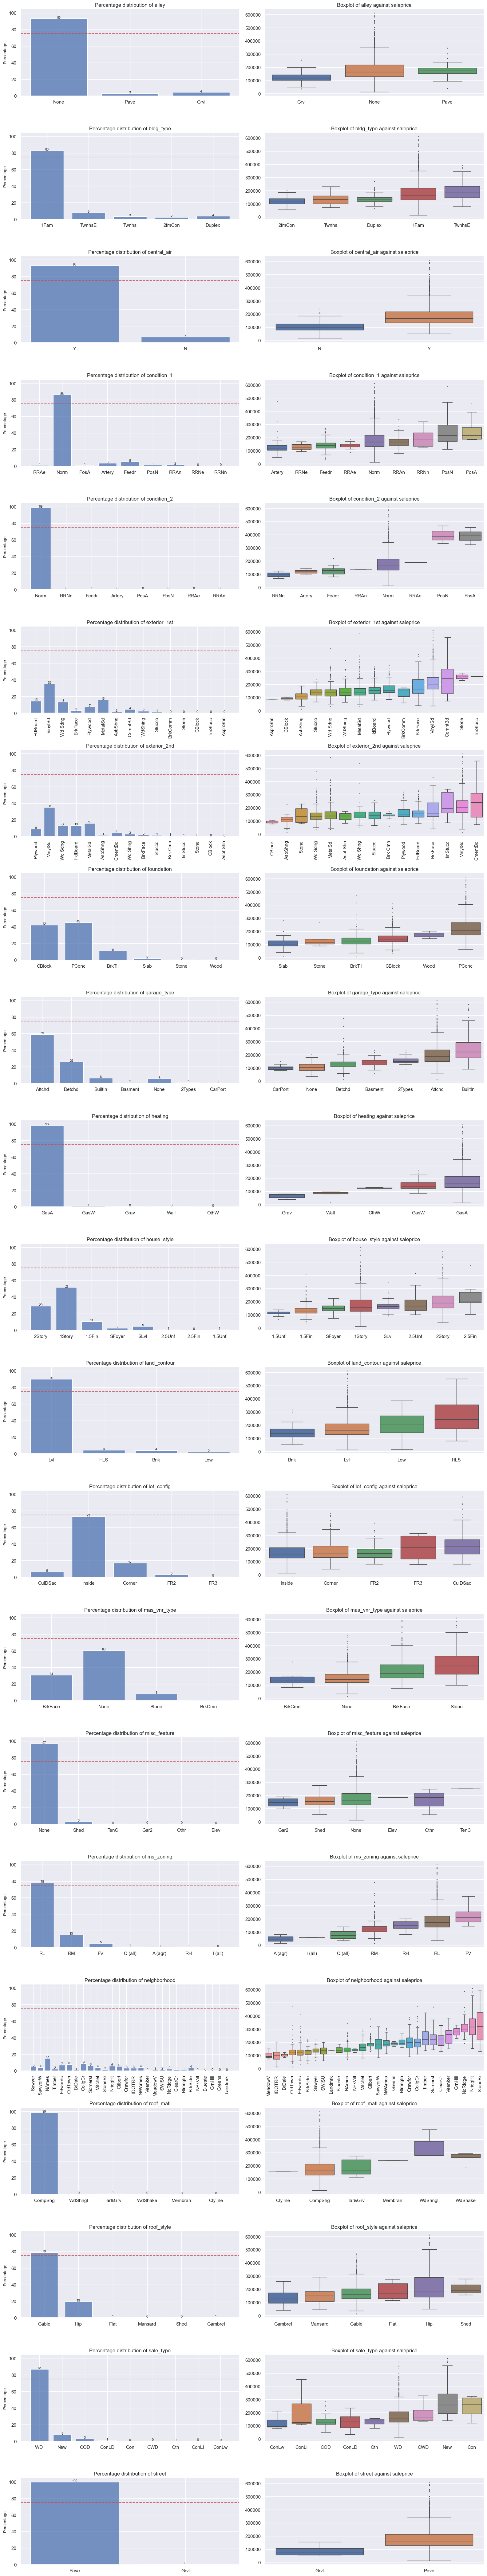

In [198]:
categorical_charts(df, nominal_var)

|Feature|Select|Rationale|Unique Values|
|:---|:---:|:---|:---:|
|*alley*|N|Low variance|3|
|*bldg_type*|N|Low variance|5|
|*central_air*|N|Low variance|2|
|*condition_1*|N|Low variance|9|
|*condition_2*|N|Low variance|8|
|*`exterior_1st`*|`Y`|Some correlation with sale price.<br>Primary exterior covering that contributes to exterior aesthetics of property|15|
|*exterior_2nd*|N|Some correlation with sale price.<br>Secondary exterior covering, so we will defer to exterior_1st only|15|
|*`foundation`*|`Y`|Some correlation with sale price.<br>Use of poured concrete has an impact on saleprice compared to other prominent options|6|
|*`garage_type`*|`Y`|Some correlation with sale price<br>Relatively high car ownership in Ames<sup>[1]</sup>|7|
|*heating*|N|Low variance|5
|*`house_style`*|`Y`|Some correlation with sale price<br>Larger houses should tend to fetch higher prices|8|
|*land_contour*|N|Low variance|4|
|*lot_config*|N|Relatively low variance and correlation with sale price|5|
|*`mas_vnr_type`*|`Y`|Some correlation with sale price<br>Contributes to exterior aesthetics of property|4|
|*misc_features*|N|Low variance|6|
|*ms_zoning*|N|Low variance|7|
|*`neighborhood`*|`Y`|Some correlation with sale price<br>Likely impacts proximity to amenities, schools, etc|28|
|*roof_matl*|N|Low variance|6|
|*roof_style*|N|Low variance|6|
|*sale_type*|N|Low variance|9|
|*street*|N|Low variance|2|

<sup>[1]</sup>Average car ownership in Ames is 2 per household source: [Data USA](https://datausa.io/profile/geo/ames-ia/)

In [199]:
# convert foundation a binary feature, 1/0 depending on whether the foundation is poured concrete
df["foundation"] = np.where(df["foundation"] == "PConc", 1, 0)

# add to discrete variables
discrete_var.append("foundation")

In [200]:
# identify features that are likely useful
f_nominal = [
    "exterior_1st",
    "garage_type",
    "house_style",
    "mas_vnr_type",
    "neighborhood",
]

`Neighbourhood` appears to have a strong ordinal relationship between the various values. This is likely due to the different amenities and facilities available, as well as proximity to certain landmarks. Due to the high number of unique values, we will convert this feature into an ordinal feature instead for modelling.

Without more specific information on the neighbourhoods at this point, we will order them based on the historical median saleprice of properties in each neighbourhood.

In [201]:
# apply ordinal encoding to neighborhoods based on median sale price
n_df = df.pivot(index=None, columns="neighborhood", values="saleprice")
sort_index = n_df.median().sort_values().index
n_dict = {value: idx for idx, value in enumerate(sort_index)}

df["neighborhood"].replace(n_dict, inplace=True)

### Ordinal Variables
---

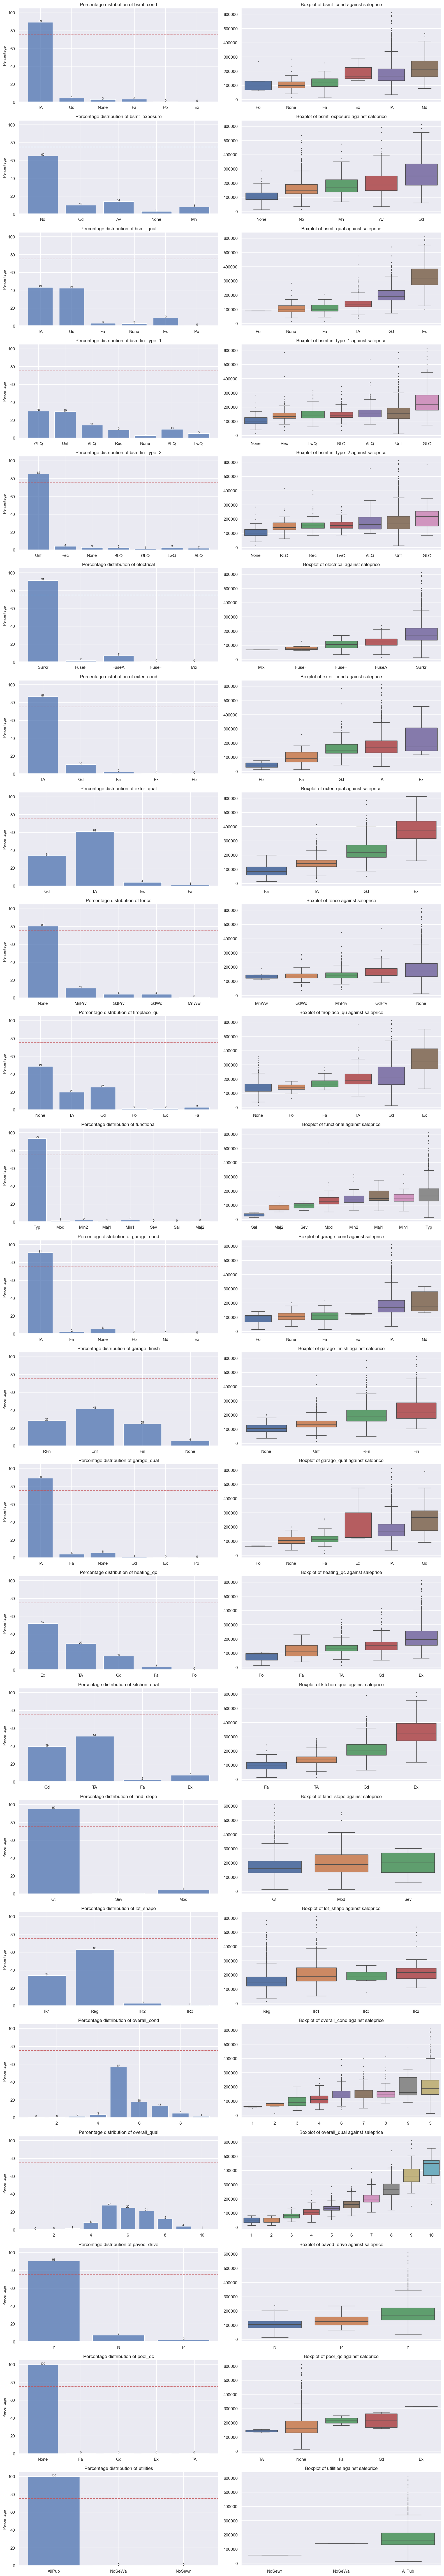

In [202]:
categorical_charts(df, ordinal_var)

|Feature|Select|Rationale|Unique Values|
|:---|:---:|:---|:---:|
|*bsmt_cond*|N|Low variance|6|
|*`bsmt_exposure`*|`Y`|Some correlation with sale price<br>Affects useability of the basements|5|
|*`bsmt_qual`*|`Y`|Some correlation with sale price<br>Affects useability of the basements|6|
|*bsmtfin_type_1*|N|Relationship with sale price does not appear to follow ordinality|7|
|*bsmtfin_type_2*|N|Low variance|7|
|*electrical*|N|Low variance|5|
|*external_cond*|N|Low variance|5|
|*`exter_qual`*|`Y`|Some correlation with sale price<br>Affects aesthetics of the property|4|
|*fence*|N|Low variance|5|
|*`fireplace_qu`*|`Y`|Some correlation with sale price<br>Relatively cool weather in Ames, provides greater comfort especially in Winter|6|
|*functional*|N|Low variance|8|
|*garage_cond*|N|Low variance|6|
|*`garage_finish`*|`Y`|Some correlation with sale price<br>Around 95% of households own at least 1 car|4|
|*garage_qual*|N|Low variance|6|
|*`heating_qc`*|`Y`|Some correlation with sale price<br>Relatively cool weather in Ames, provides greater comfort especially in Winter|5|
|*`kitchen_qual`*|`Y`|Some correlation with sale price<br>Expected to rate the useability of the kitchen|4|
|*land_slope*|N|Low variance|3|
|*lot_shape*|N|Relationship with sale price does not follow ordinality|4|
|*overall_cond*|N|Relationship with sale price does not follow ordinality|9|
|*`overall_qual`*|`Y`|Strong correlation with sale price<br>Expected to affect the value of the property|10|
|*paved_drive*|N|Low variance|3|
|*pool_qc*|N|Low variance|5|
|*utilities*|N|Low variance|3|

In [203]:
# identify features that are likely useful
f_ordinal = [
    "bsmt_exposure",
    "bsmt_qual",
    "exter_qual",
    "fireplace_qu",
    "garage_finish",
    "heating_qc",
    "kitchen_qual",
    "overall_qual",
    "neighborhood" # from nominal features
]

The ordinal features that measure the quality of the property appear to have the most direct impact on the sale price.

Instead of using labels, a numerical representation can also better reflect the ordinal relationship between the categories. This also allows us to use a heatmap to visualise the correlation with our target variable, as well as any correlation between the features.

In [204]:
def ord_to_num(dataframe, variables):
    for col in variables:
        if ("qu" in col) or ("qc" in col):
            dataframe[col].replace({"None": 0, "Po" : 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}, inplace=True)
        elif "finish" in col:
            dataframe[col].replace({"None": 0, "Unf": 1, "RFn": 2, "Fin": 3}, inplace=True)
        elif "exposure" in col:
            dataframe[col].replace({"None":0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}, inplace=True)
        elif "neighborhood" in col:
            dataframe[col].replace(n_dict, inplace=True)

In [205]:
ord_to_num(df, f_ordinal)

# check transformation
df[f_ordinal].head()

bsmt_exposure  bsmt_qual  exter_qual  fireplace_qu  garage_finish  \
0              1          3           4             0              2   
1              1          4           4             3              2   
2              1          3           3             0              1   
3              1          4           3             0              3   
4              1          2           3             0              1   

   heating_qc  kitchen_qual  overall_qual  neighborhood  
0           5             4             6             6  
1           5             4             7            14  
2           3             4             5            10  
3           4             3             5            20  
4           3             3             6            14

In [206]:
# create function to plot seaborn heatmap to visualise correlation between numerical features and target
def plot_corr(dataframe, variables, target):
    # filter out features with > 0.5 correlation with target variable
    corr = dataframe[variables].corrwith(dataframe[target])
    corr = corr[corr > 0.5]
    
    temp_df = dataframe[corr.index].merge(
        dataframe[target], left_index=True, right_index=True
    )

    # create heatmap mask
    mask = np.triu(np.ones_like(temp_df.corr(), dtype=bool))

    # plot seaborn heatmap to check for collinearity with other features
    ax_size = len(temp_df.columns)
    plt.figure(figsize=(ax_size, ax_size))
    plt.title("Features with >0.5 Correlation with Sale Price")
    sns.heatmap(temp_df.corr(), annot=True, vmax=1, vmin=-1, cmap="Spectral", mask=mask)

    # plot pairplots
    sns.pairplot(temp_df)
    plt.tight_layout();


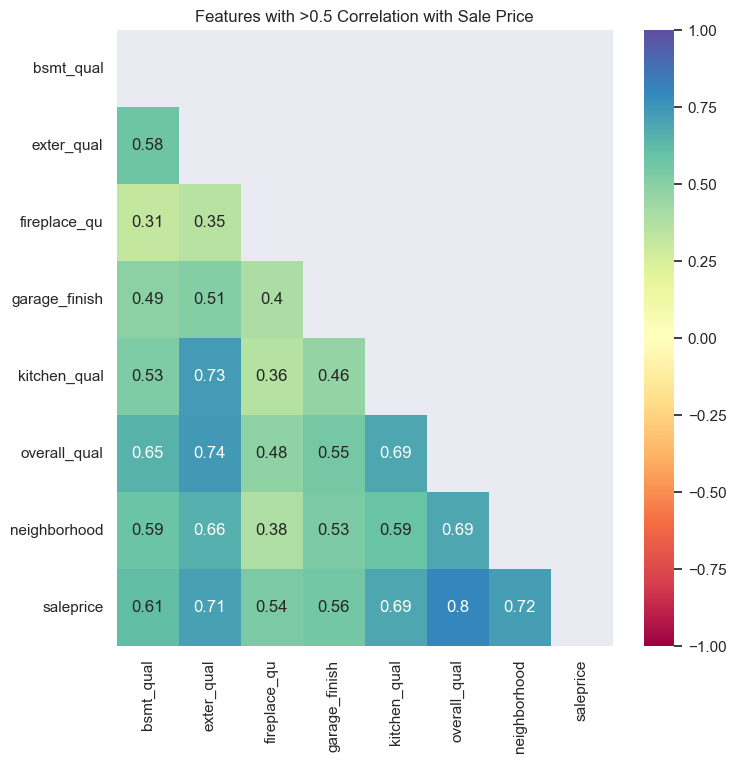

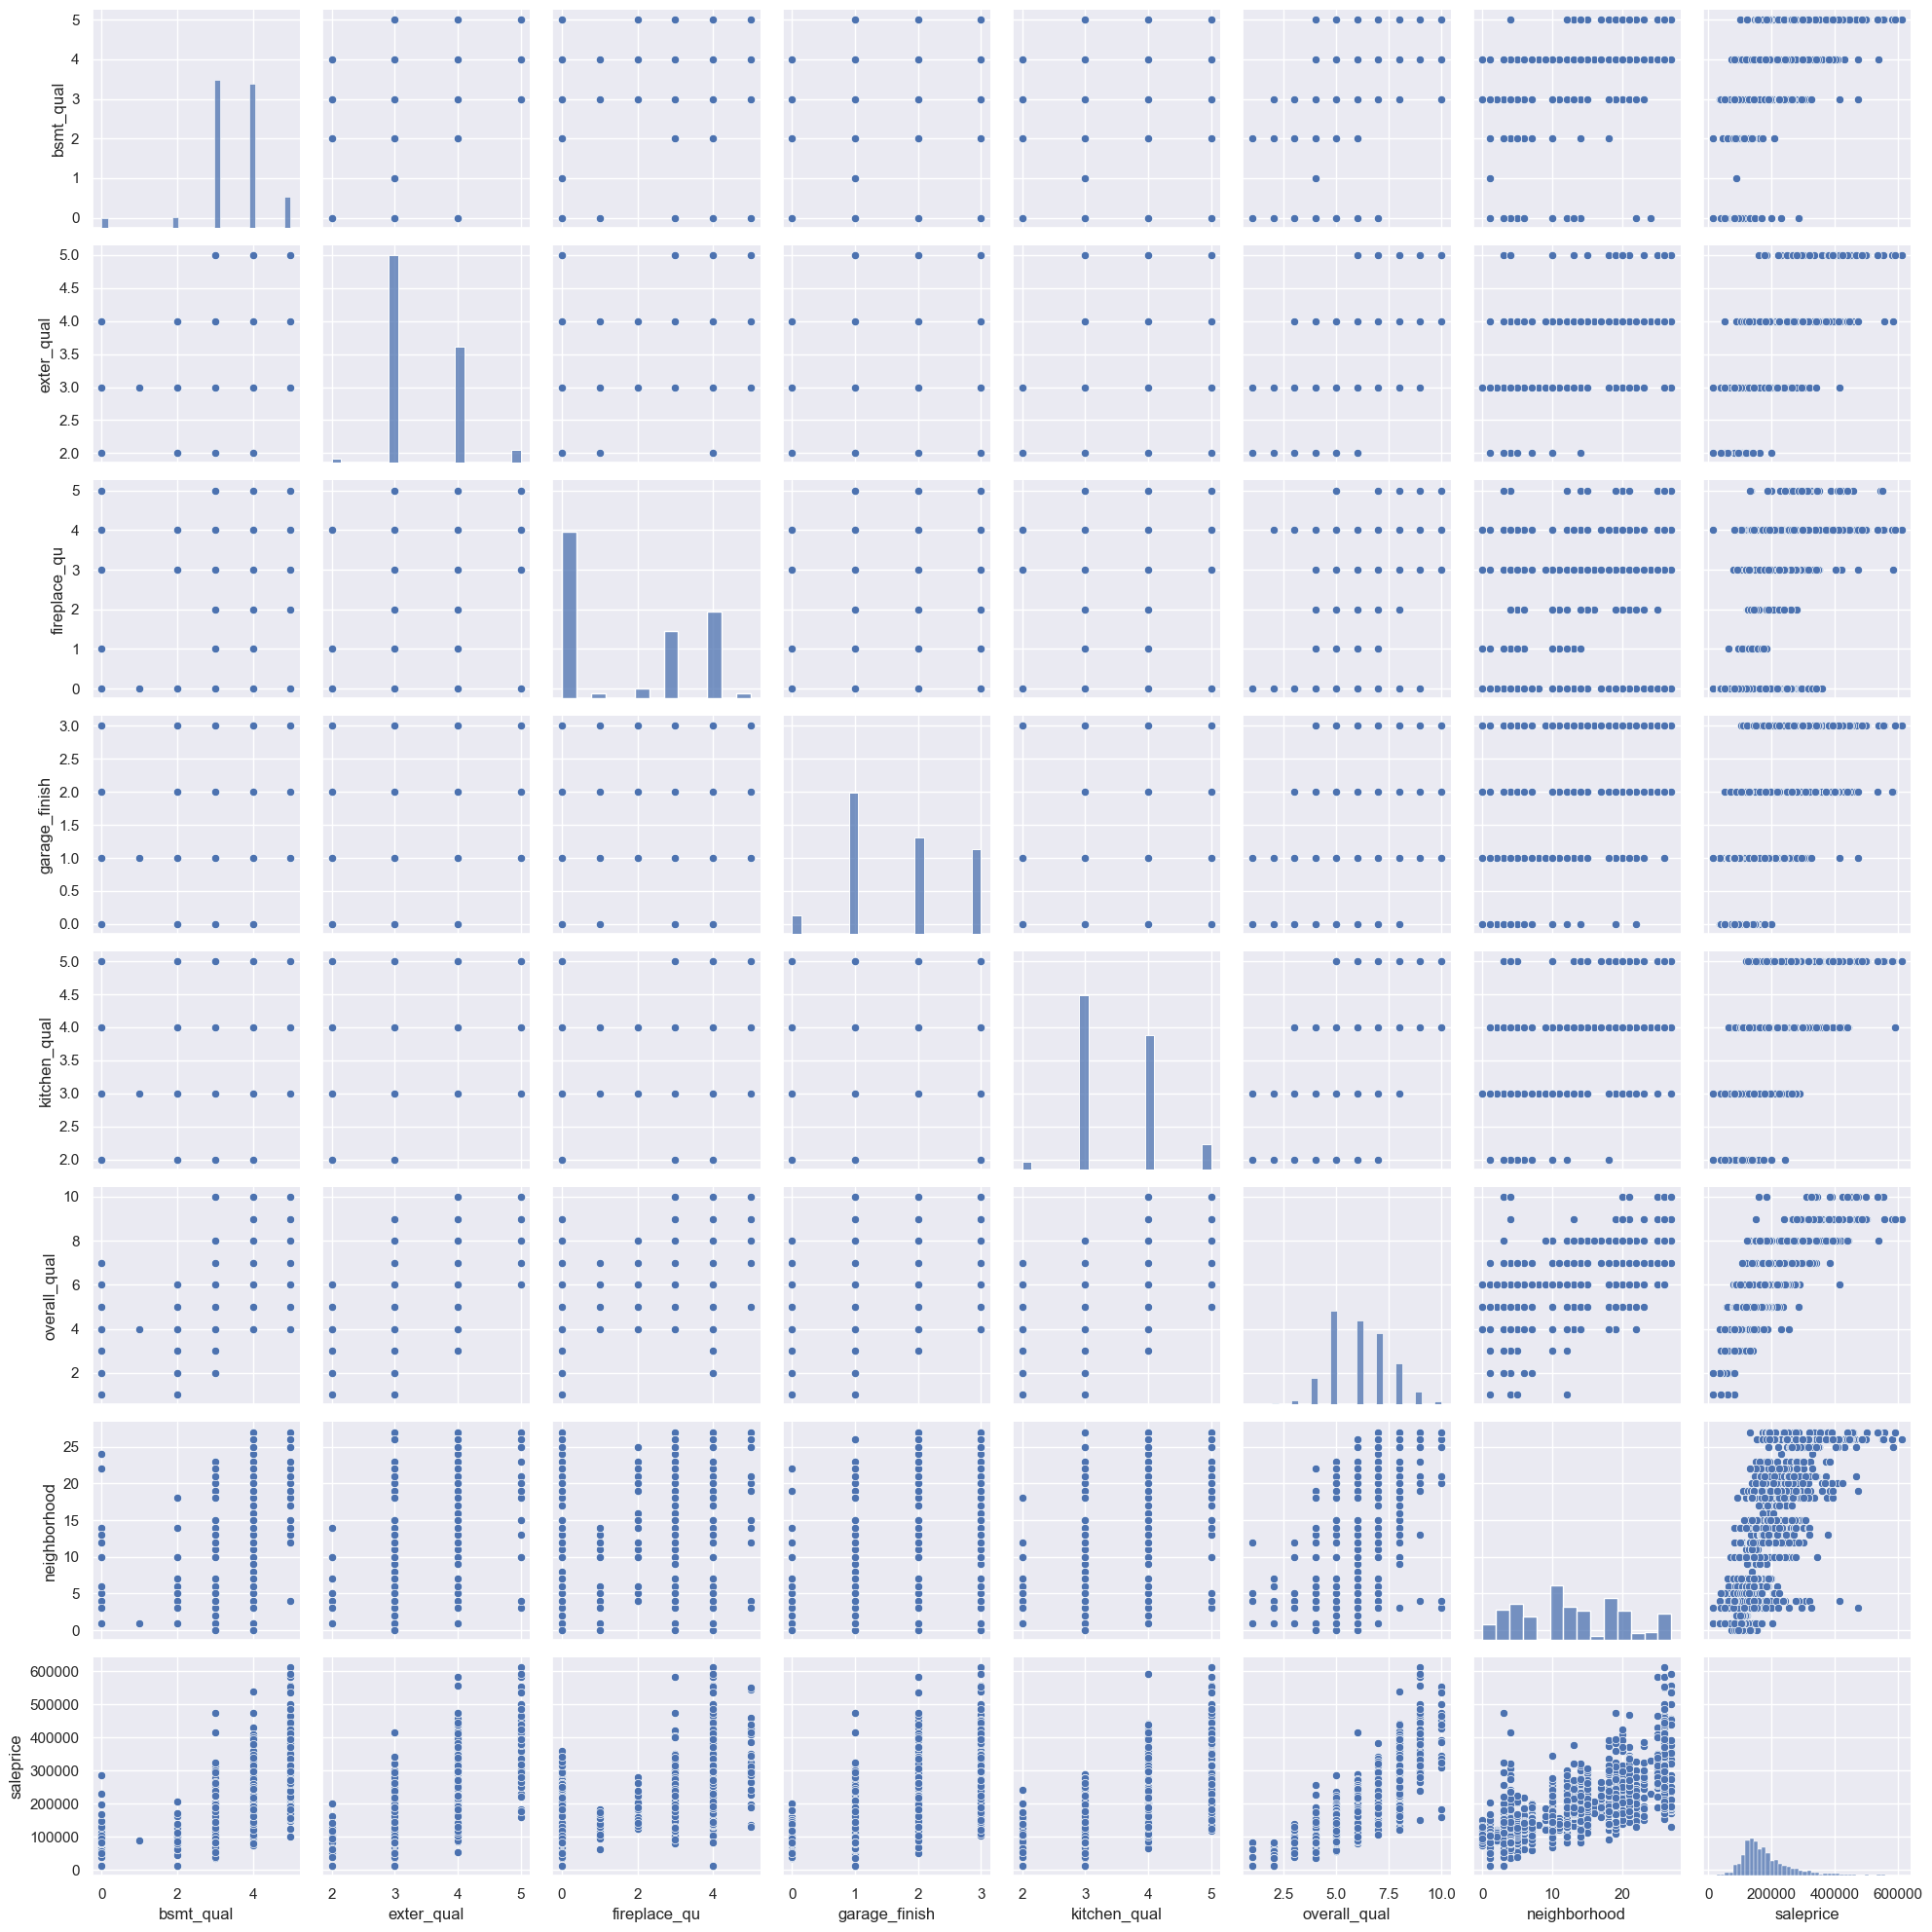

In [207]:
plot_corr(df, f_ordinal, "saleprice")

Based on the heatmap, `overall_qual` has the strongest correlation with our target `saleprice`. However, it also has a strong correlation with exter_qual and relatively strong correlation with kitchen_qual and bsmt_qual. This may be expected since these features measure the quality of various parts of the property and may then contribute to the overall score.

As such, we will drop the correlated features from our selection and retain only overall_qual.

In [208]:
f_ordinal.remove("exter_qual")
f_ordinal.remove("kitchen_qual")
f_ordinal.remove("bsmt_qual")

Two features bsmt_exposure and heating_qc have a < 0.5 correlation with saleprice so we will drop these 2 features. 

In [209]:
f_ordinal.remove("bsmt_exposure")
f_ordinal.remove("heating_qc")

While they only have a moderate correlation with sale price, we will retain `fireplace_qu` and `garage_finish` as these would be added bonuses to home owners and there is no strong correlation with the other features.

Neighborhood has a strong correlation with overall_qual, which may affect the accuracy of our model. By using the median saleprice to convert the neighbourhoods into an ordinal variable, we have also inadvertently created a feature that is dependent on the target variable. This would likely affect the ability of our model to perform real-time predictions when the saleprice is unknown. 

This may also suggest that there could be other underlying factors contributing to the difference in saleprice in each neighbourhood, perhaps proximity to Iowa State University or desirability of the neighbourhoods due to socioeconomic status, etc, which has not been captured in our data. This may warrant further investigation in our future work.

In [210]:
f_ordinal.remove("neighborhood")
f_ordinal

['fireplace_qu', 'garage_finish', 'overall_qual']

### Discrete Variables
---

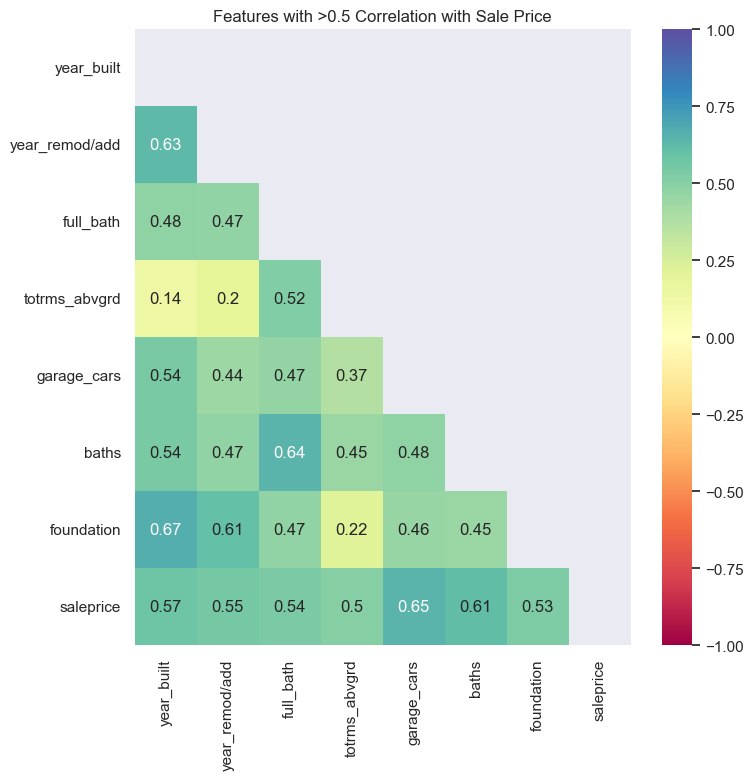

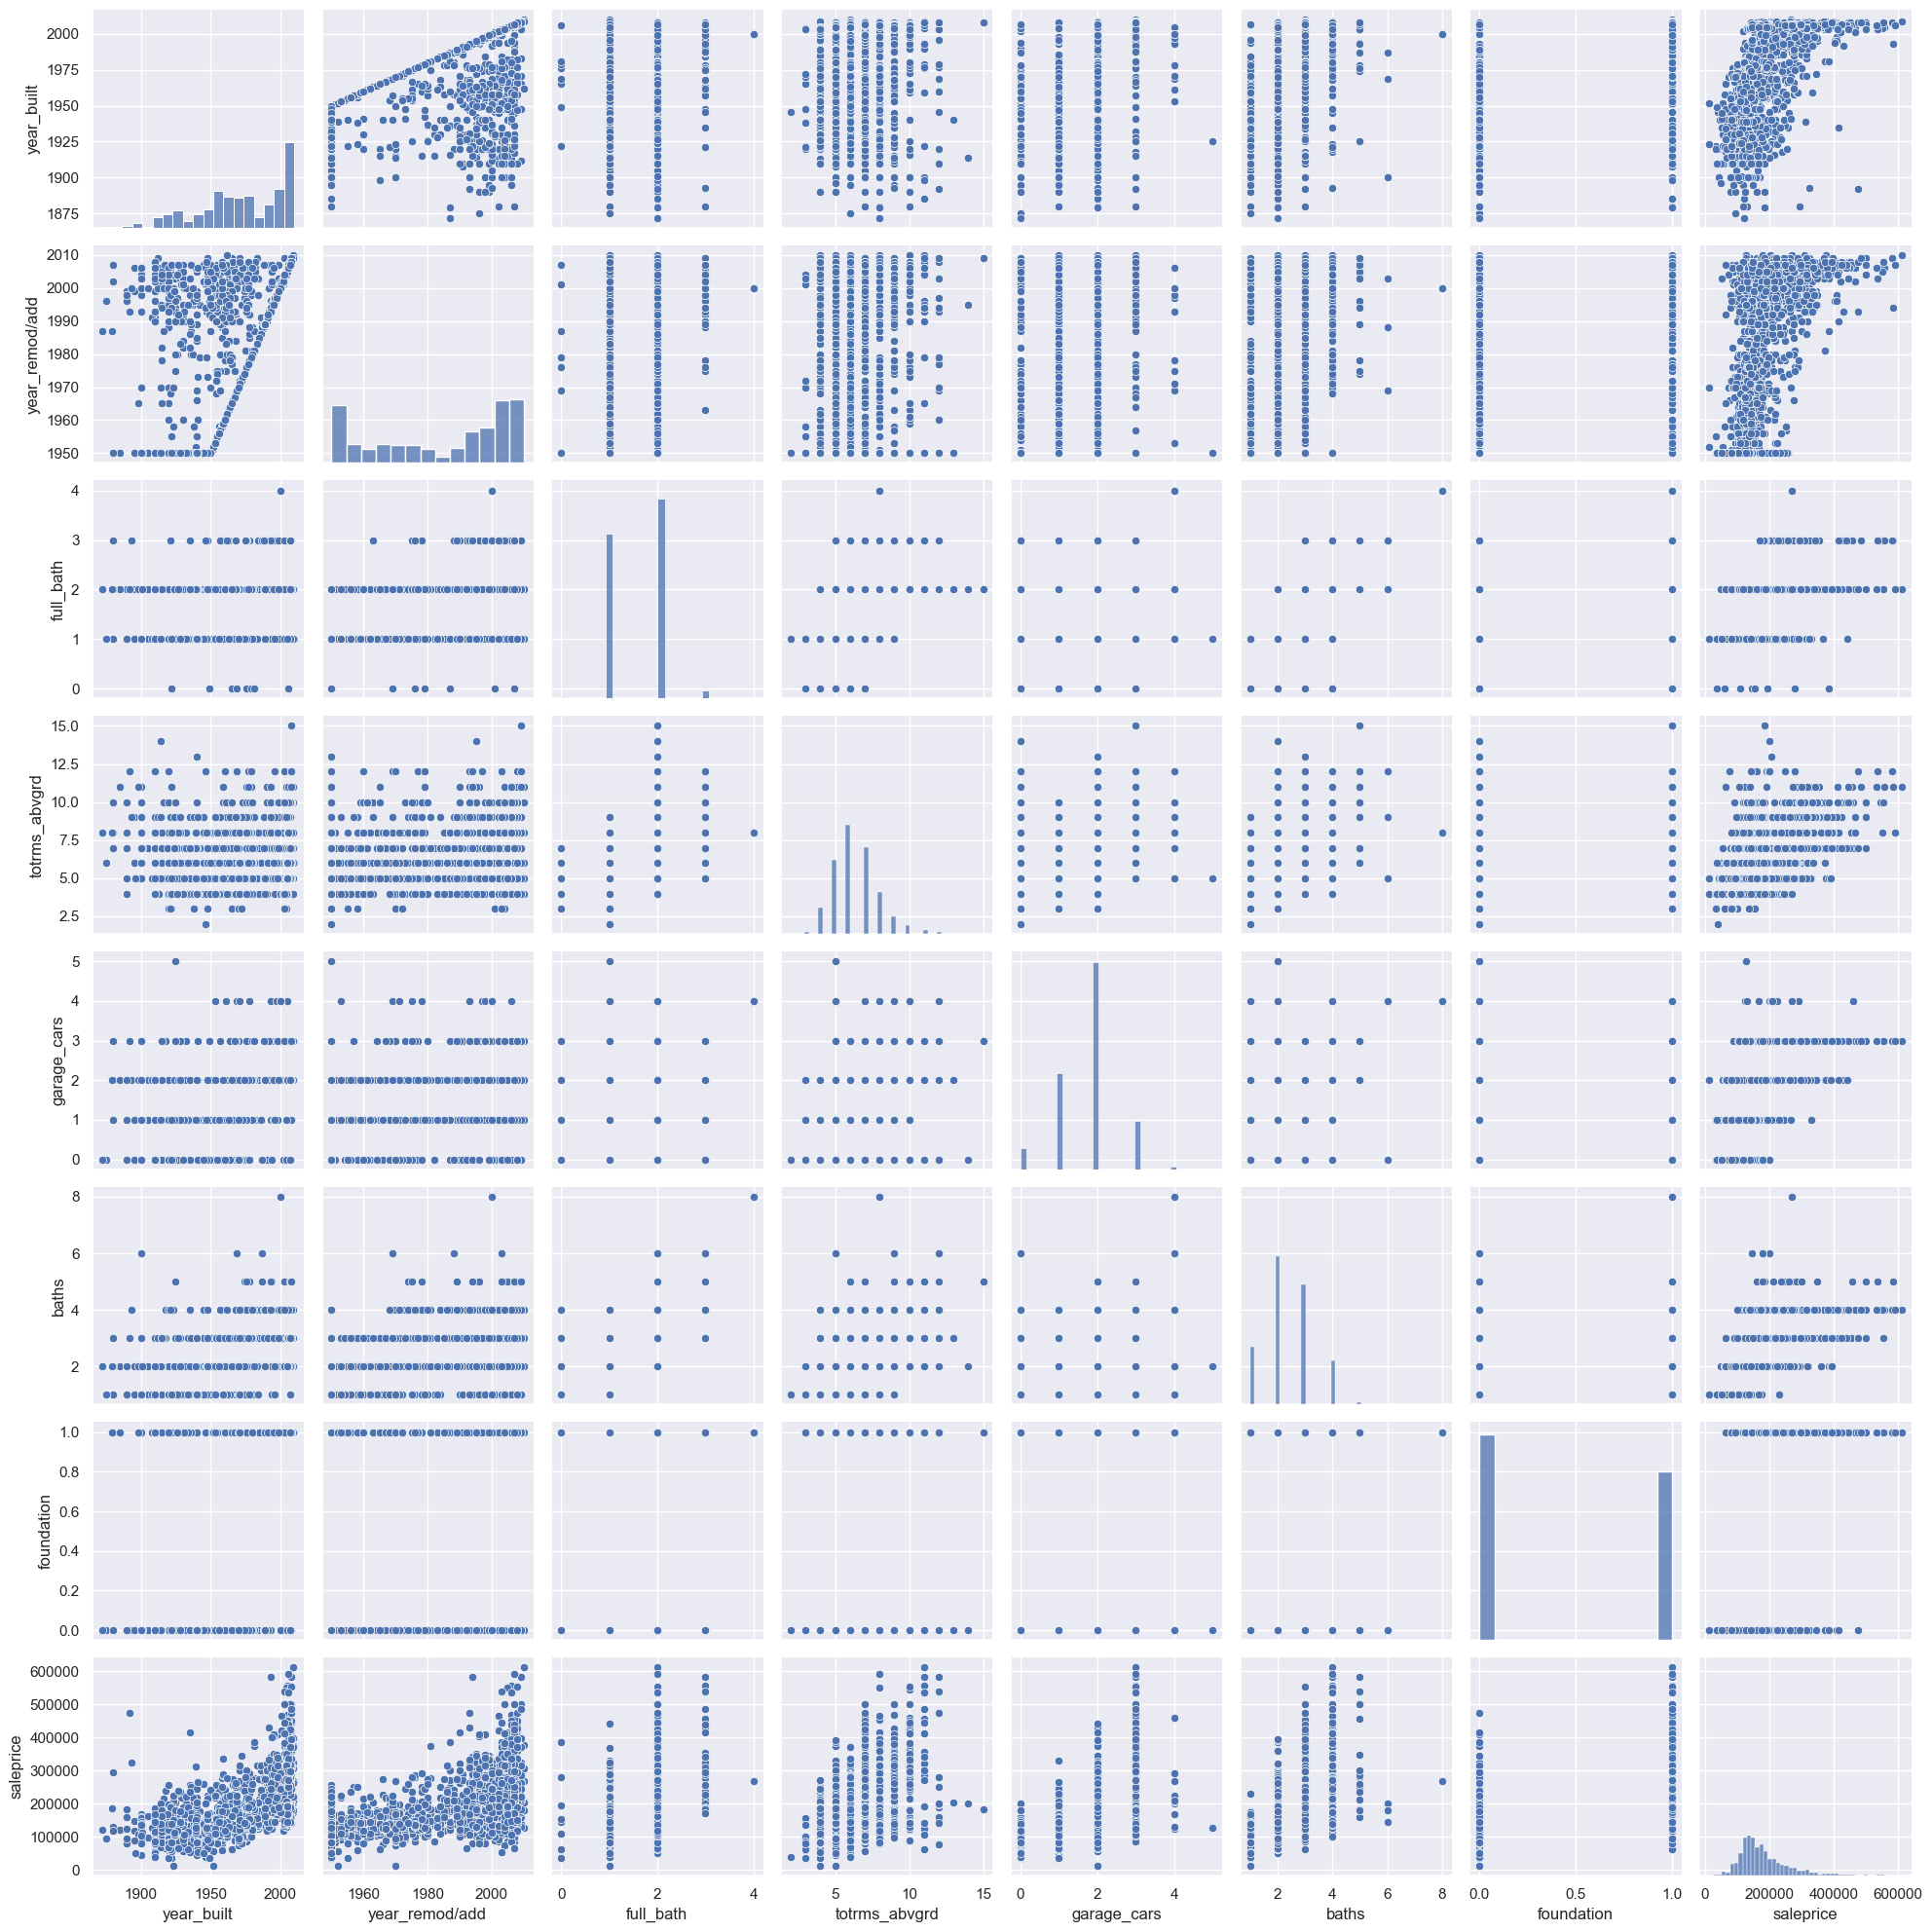

In [211]:
plot_corr(df, discrete_var, "saleprice")

The age feature created has < 0.5 correlation with sale price and does not show on the charts, although year_built also shows a moderate correlation.

The `baths` feature we created and `garage_cars` have a stronger correlation with sale price.

In [212]:
# identify features that may be useful with corr > 0.6
f_discrete = ["garage_cars", "baths"]

### Continuous Variables
---
Based on the data, there are some features which are directly related:
- `gr_liv_area` = 1st_flr_sf + 2nd_flr_sf
- `total_bsmt_sf` = bsmt_unf_sf + bsmtfin_sf_1 + bsmtfin_sf_2

While basement area is often not included as part of overall square footage when assessing a property, home owners may see value in having high quality basements that can be utilised as living space. We will create some additional features for analysis.

In [213]:
df["living_area"] = (
    df["gr_liv_area"] + df["enclosed_porch"] + df["3ssn_porch"] + df["wood_deck_sf"] + df["open_porch_sf"] + df["screen_porch"] + df["pool_area"]
)

df["total_built_area"] = (
    df["living_area"] + df["garage_area"]
)

continuous_var.append("living_area")
continuous_var.append("total_built_area")

In [214]:
# check for the newly created features
df[continuous_var].tail()

lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmtfin_sf_2  \
2046          79.0     11449           0.0        1011.0           0.0   
2047          68.0     12342           0.0         262.0           0.0   
2048          57.0      7558           0.0           0.0           0.0   
2049          80.0     10400           0.0         155.0         750.0   
2050          60.0      7500           0.0           0.0           0.0   

      bsmt_unf_sf  total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  \
2046        873.0         1884.0        1728           0                0   
2047        599.0          861.0         861           0                0   
2048        896.0          896.0        1172         741                0   
2049        295.0         1200.0        1200           0                0   
2050        994.0          994.0        1028         776                0   

      gr_liv_area  garage_area  wood_deck_sf  open_porch_sf  enclosed_porch  \
2046         1728        520.0             0            276               0   
2047          861        539.0           158              0               0   
2048         1913        342.0             0              0               0   
2049         1200        294.0             0            189             140   
2050         1804        442.0           140             60               0   

      3ssn_porch  screen_porch  pool_area  misc_val  living_area  \
2046           0             0          0         0         2004   
2047           0             0          0         0         1019   
2048           0             0          0         0         1913   
2049           0             0          0         0         1529   
2050           0             0          0         0         2004   

      total_built_area  
2046            2524.0  
2047            1558.0  
2048            2255.0  
2049            1823.0  
2050            2446.0

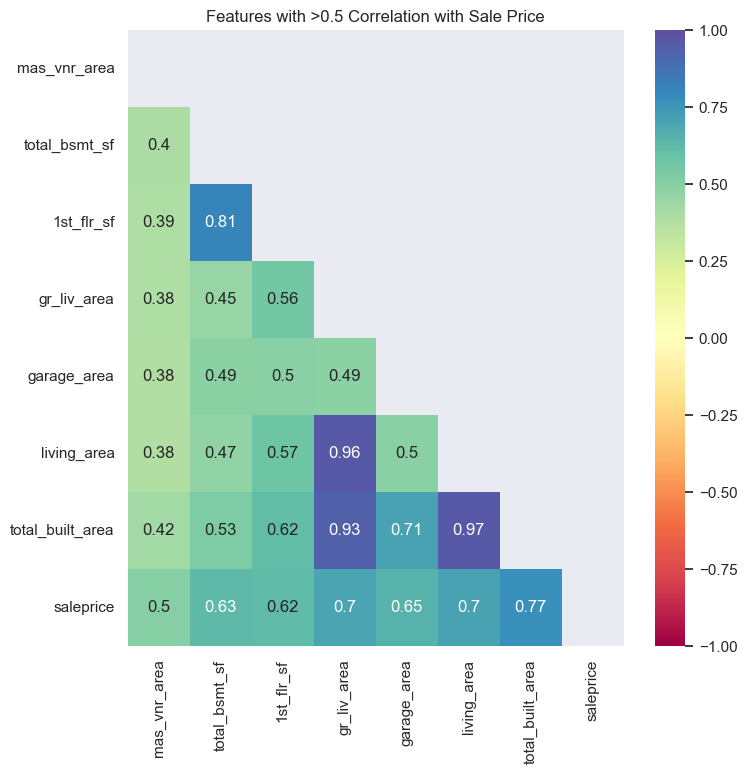

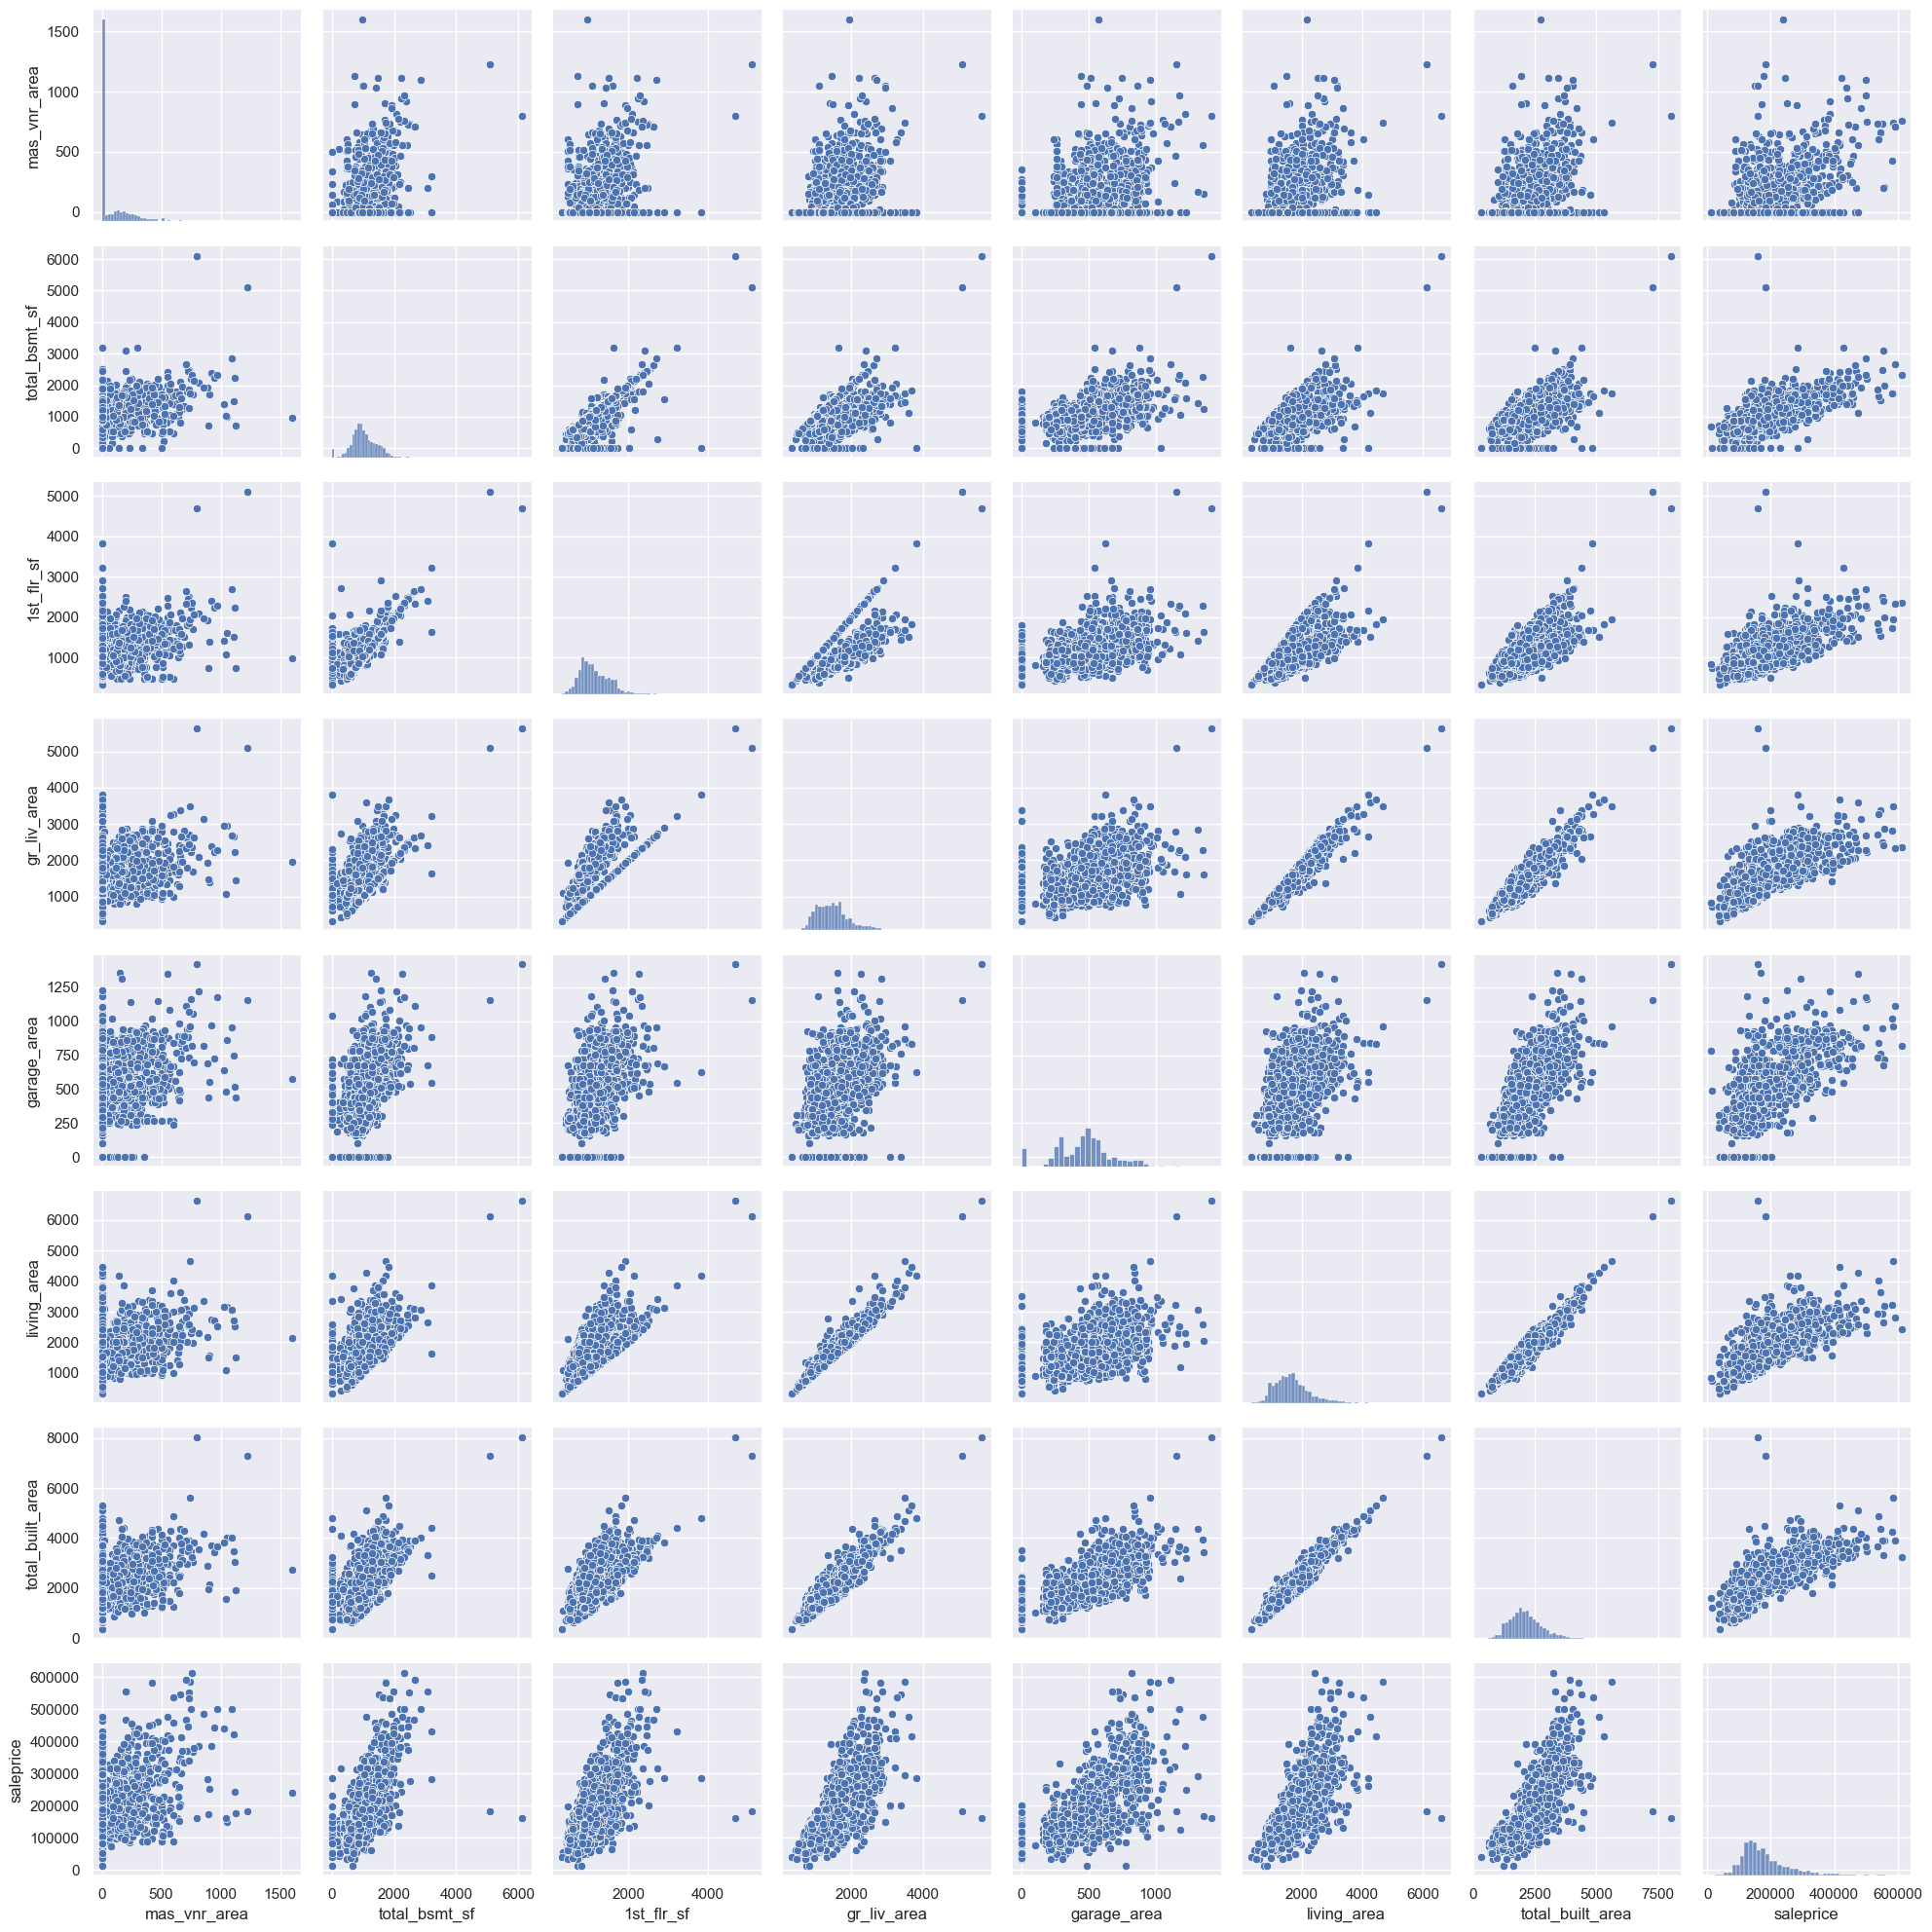

In [215]:
plot_corr(df, continuous_var, "saleprice")

Of all the features, the engineered feature `total_built_area` has the strongest correlation with sale price. We will select the feature and drop all the remaining features that were used to create this feature as they also have high collinearity with this feature.

In [216]:
# identify features with a strong correlation
f_continuous = ["total_built_area"]

From the pairplots, we detect that there may be 2 outliers in the dataset based on the scatterplots between saleprice and total_area. Despite the large areas, these properties were sold for very low prices and may not have been indicative of a normal market transaction. As there are only 2 rows out of our dataset, we will drop these 2 outliers.

In [217]:
df.loc[df["total_built_area"] > 6000, :]

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
960   1499  908154235           60        RL         313.0     63887   Pave   
1885  2181  908154195           20        RL         128.0     39290   Pave   

     alley lot_shape land_contour utilities lot_config land_slope  \
960   None       IR3          Bnk    AllPub     Corner        Gtl   
1885  None       IR1          Bnk    AllPub     Inside        Gtl   

      neighborhood condition_1  ... 3ssn_porch screen_porch pool_area  \
960              4       Feedr  ...          0            0       480   
1885             4        Norm  ...          0            0         0   

      pool_qc  fence  misc_feature  misc_val mo_sold yr_sold sale_type  \
960        Gd   None          None         0       1    2008       New   
1885     None   None          Elev     17000      10    2007       New   

     saleprice age  baths  living_area total_built_area  
960     160000   0    5.0         6628           8046.0  
1885    183850  -2    5.0         6125           7279.0  

[2 rows x 85 columns]

In [218]:
df.drop([960, 1885], inplace=True)

Evaluating the selected numeric variables to check for collinearity that may affect the model.

In [219]:
# combine the numeric features
f_numeric = f_discrete + f_continuous + f_ordinal

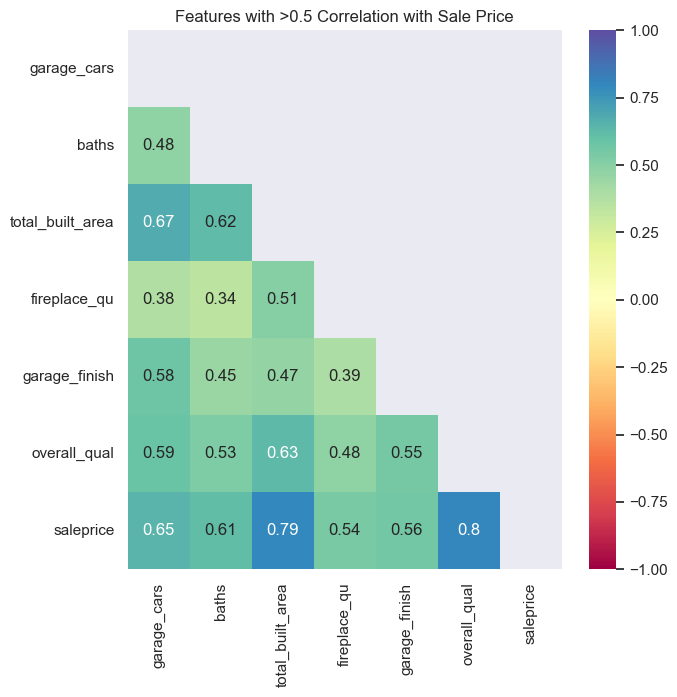

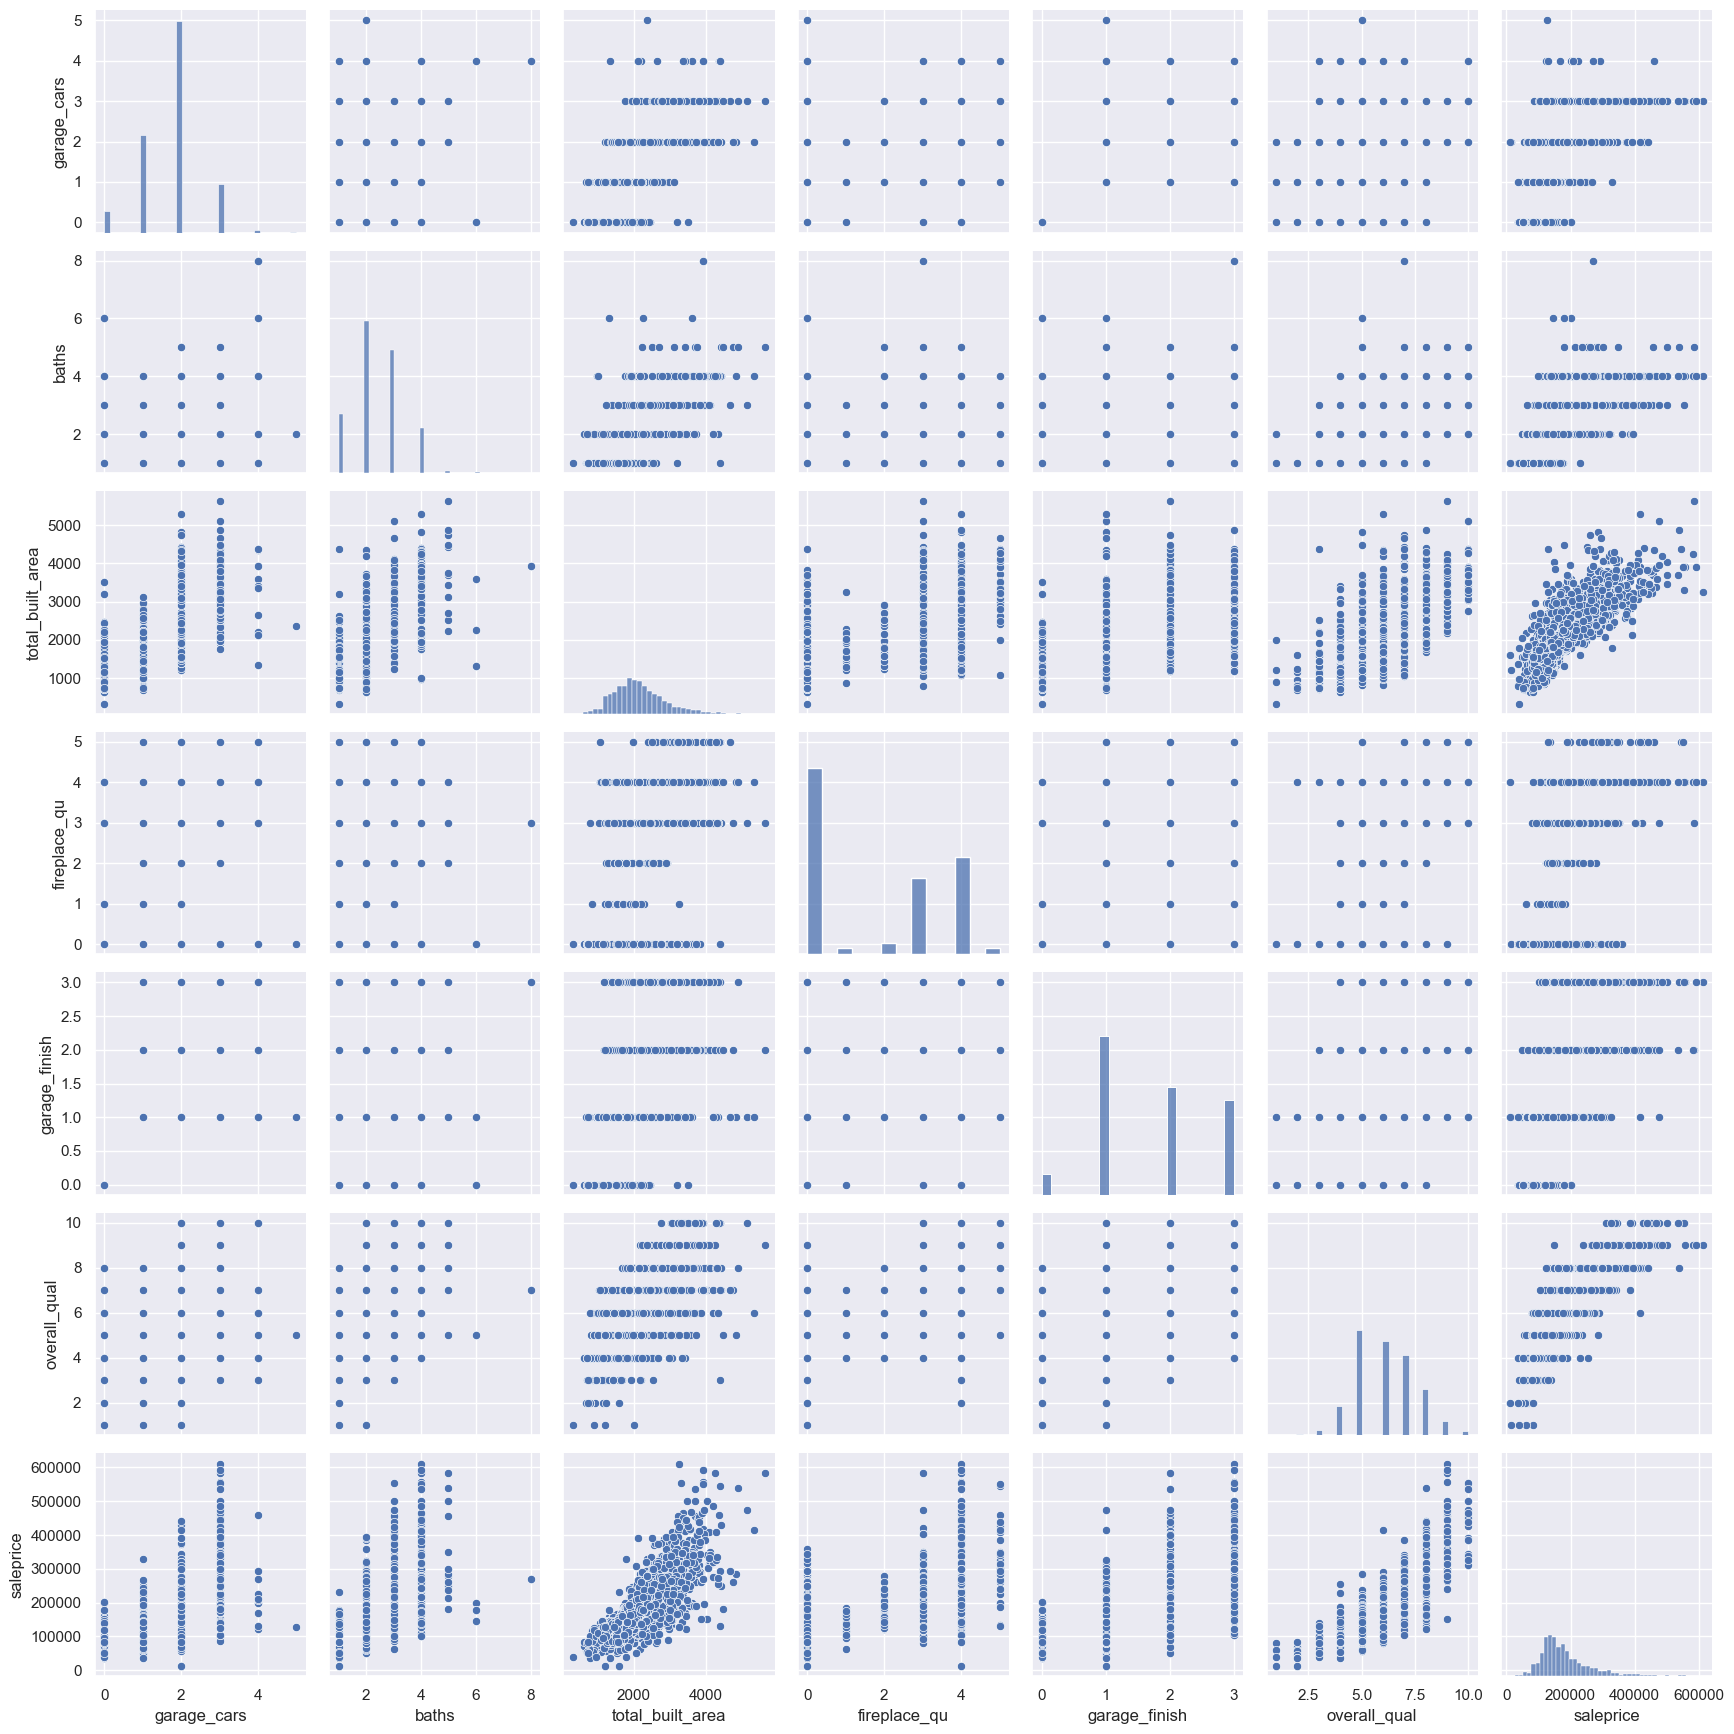

In [220]:
# check for collinearity between numeric variables
plot_corr(df, f_numeric, "saleprice")

While garage_cars has a moderate correlation with saleprice, it also has a moderate correlation with our total_built_area feature, since they both include a measure of the size of the garage. We will drop garage_cars and utilise only the `total_built_area` feature in our model.

In [221]:
f_discrete.remove("garage_cars")

## Feature Selection
---
Through the EDA process, we have identified the below features to use with our regression models. These are features that have a correlation with saleprice and would likely also be factors that our clients would be interested in.

In [222]:
# combine selected features to prepare features matrix
f_numeric = f_discrete + f_continuous

features = f_numeric + f_nominal + f_ordinal

In [223]:
# selected features to utilise in our model
print(f"{len(f_nominal)} Nominal features: {f_nominal}\n")
print(f"{len(f_ordinal)} Ordinal features: {f_ordinal}\n")
print(f"{len(f_numeric)} Numeric features: {f_numeric}")

6 Nominal features: ['exterior_1st', 'garage_type', 'house_style', 'lot_config', 'mas_vnr_type', 'neighborhood']

3 Ordinal features: ['fireplace_qu', 'garage_finish', 'overall_qual']

2 Numeric features: ['baths', 'total_built_area']


Based on the identified features, we will utilise them in our model to attempt to predict the sale price of a property.

In [224]:
# define a function to engineer the new columns in our data sets
def feature_engineer(dataframe):
    dataframe["total_area"] = (
        # dataframe["total_bsmt_sf"]
        + dataframe["garage_area"]
        + dataframe["open_porch_sf"]
        + dataframe["pool_area"]
        + dataframe["screen_porch"]
        + dataframe["3ssn_porch"]
        + dataframe["enclosed_porch"]
        + dataframe["wood_deck_sf"]
        + dataframe["gr_liv_area"]
    )
    dataframe["baths"] = (
        dataframe["bsmt_full_bath"]
        + dataframe["bsmt_half_bath"]
        + dataframe["full_bath"]
        + dataframe["half_bath"]
    )

Lastly, we will check our target variable `saleprice` prior to modelling.

1.5565344779493424

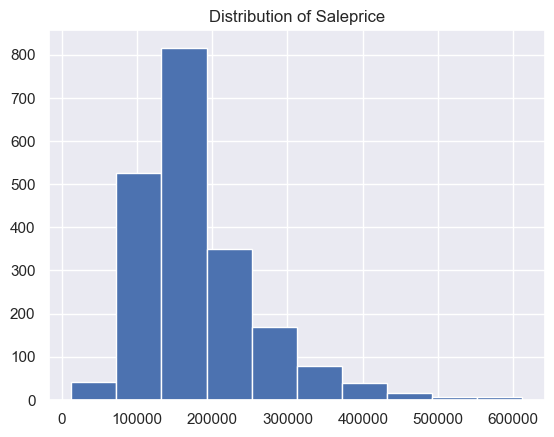

In [225]:
df["saleprice"].hist()
plt.title("Distribution of Saleprice")

df["saleprice"].skew()

Our target variable has a right skew of 1.55 with outliers towards the right, which may affect our predictions. We will apply a binary log to the variable to check if this reduces the skew.

-0.14655790987190442

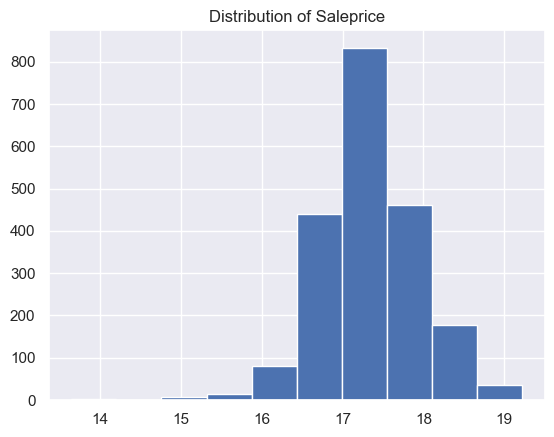

In [226]:
# # reduce skewness of target variable
check = df.saleprice.map(np.log2)

check.hist()
plt.title("Distribution of Saleprice")

check.skew()

From the chart, we see that the values are now closer to a normal distribution, which would aid in our model accuracy. When interpreting the results, the binary log transformation will need to be reversed.

The modelling process will be continued in the [model notebook](model.ipynb).